Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs
import tarfile

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, decraoff=None, unit='arcsec', axis_label=None, colorbar=False):
    '''
    decraoff: [dec_offset, ra_offset]
    '''
    if unit=='arcsec':
        rescale = 1.
    elif unit=='arcmin':
        rescale = 60.
    elif unit=='deg':
        rescale = 3600.
    else:
        raise ValueError('unrecognized unit')
    extent = 0.5*pixscale*(img.shape[1]*np.array([-1, 1, 0, 0])+img.shape[0]*np.array([0, 0, -1, 1]))/rescale

    if decraoff is not None:
        dec_offset, ra_offset = decraoff
        extent[0] -= dec_offset # DEC
        extent[1] -= dec_offset # DEC
        extent[2] += ra_offset # RA
        extent[3] += ra_offset # RA
    
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal',
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    if colorbar:
        fig.colorbar(dens, fraction=0.046, pad=0.04)
    ax.grid(alpha=0.5)
    if axis_label is not None:
        ax.set_xlabel(axis_label[0])
        ax.set_ylabel(axis_label[1])
    return ax

def plot_cutout_sidebyside(img1, img2, title1, title2, pixscale, decraoff=None, vmin=-1, vmax=1, unit='arcsec', axis_label=None, axis=None):
    '''
    decraoff: [dec_offset, ra_offset]
    '''
    if unit=='arcsec':
        rescale = 1.
    elif unit=='arcmin':
        rescale = 60.
    elif unit=='deg':
        rescale = 3600.
    else:
        raise ValueError('unrecognized unit')
    extent = 0.5*pixscale*(img.shape[1]*np.array([-1, 1, 0, 0])+img.shape[0]*np.array([0, 0, -1, 1]))/rescale

    if decraoff is not None:
        dec_offset, ra_offset = decraoff
        extent[0] -= dec_offset # DEC
        extent[1] -= dec_offset # DEC
        extent[2] += ra_offset # RA
        extent[3] += ra_offset # RA
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(img1, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    axes[0].axvline(0, ls='--', lw=0.5, color='grey')
    axes[0].axhline(0, ls='--', lw=0.5, color='grey')
    axes[0].set_title(title1)
    im = axes[1].imshow(img2, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    axes[1].axvline(0, ls='--', lw=0.5, color='grey')
    axes[1].axhline(0, ls='--', lw=0.5, color='grey')
    axes[1].set_title(title2)
    if axis_label is not None:
        axes[0].set_xlabel(axis_label[0])
        axes[0].set_ylabel(axis_label[1])
        axes[1].set_xlabel(axis_label[0])
        axes[1].set_ylabel(axis_label[1])
    # fig.colorbar(im, fraction=0.046, pad=0.04)
    if axis is not None:
        axes[0].axis(axis)
        axes[1].axis(axis)
    return axes

In [4]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_moffat_plus_power_law(r, alpha1, beta1, beta2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 *r**(-2*beta2)
    return i

In [5]:
params = {
'g_moffat_norm': 1.002, 'g_weight2': 0.00045, 'g_beta2': 1.0000464,
'r_moffat_norm': 1.002, 'r_weight2': 0.00033, 'r_beta2': 1.0000464,
'z_moffat_norm': 1.005, 'z_weight2': 0.015, 'z_beta2': 1.4,
}

band = 'r'
field = 'south'
region_name = 'decals_ngc'

if (field=='north') and ((band=='g') or (band=='r')):
    pixscale = 0.454
else:
    pixscale = 0.262

download_dir = '/global/homes/r/rongpu/temp/tmp/dr8_ccd_cutouts'

vrange = 0.2

         5         4          3         2
-0.1829 x + 0.394 x + 0.6065 x - 1.176 x - 3.478 x - 2.332
0.451153205656


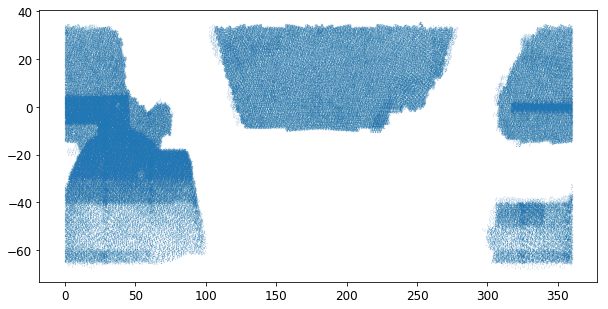

In [6]:
# load polynomial fit
if (field=='north') and ((band=='g') or (band=='r')):
    pixscale = 0.454
else:
    pixscale = 0.262

# PSF profile of a 22.5 mag star (in nmgy/pixel)
tmp = np.loadtxt('../data/{}_poly_fit.txt'.format(region_name))
band_index = np.where(band==np.array(['g', 'r', 'z']))[0][0]
poly = np.poly1d(tmp[band_index])
print(poly)
profile_fit = np.poly1d(poly)

# ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec', 'ccd_cuts', 'ccdzpt', 'exptime', 'ccdskycounts', 'ccdskysb']
ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec', 'ccd_cuts', 'ccdzpt', 'exptime']

surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/reorg/decam/survey-ccds-decam-dr8-newlocs2.fits.gz'
# annotatedccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/reorg/decam/ccds-annotated-decam-dr9-newlocs2.fits.gz'
# surveyccd_dir = '/Users/rongpu/Documents/Data/desi_misc/dr8'

if field=='south':
    ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
#     accd = fitsio.read(annotatedccd_path, columns=['meansky'])
# elif field=='north' and band=='z':
#     ccd = fitsio.read(os.path.join(surveyccd_dir, 'survey-ccds-mosaic-dr8.fits.gz'), columns=ccd_columns)
# elif field=='north' and (band=='g' or band=='r'):
#     ccd = fitsio.read(os.path.join(surveyccd_dir, 'survey-ccds-90prime-dr8.fits.gz'), columns=ccd_columns)
else:
    raise ValueError

ccd = Table(ccd)
# accd = Table(accd)
# ccd = hstack([ccd, accd])
mask = ccd['ccd_cuts']==0
print(np.sum(mask)/len(mask))
ccd = ccd[mask]

plt.figure(figsize=(10, 5))
plt.plot(ccd['ra'][::10], ccd['dec'][::10], '.', ms=0.1)
plt.show()

gaia = Table.read('/global/homes/r/rongpu/notebooks/bright_star_profiles/data/gaia_sample_for_ccd_cutouts-decals_ngc.fits')

In [10]:
gaia_index = 0
ccd1_index = 0

198.338561455 -3.49457794573
phot_g_mean_mag =  6.80578
ls_r =  6.67489347293
3 CCD images available
seeing = 1.35 arcsec
airmass = 1.12
alpha, beta =  [ 0.96814433  2.44850762]


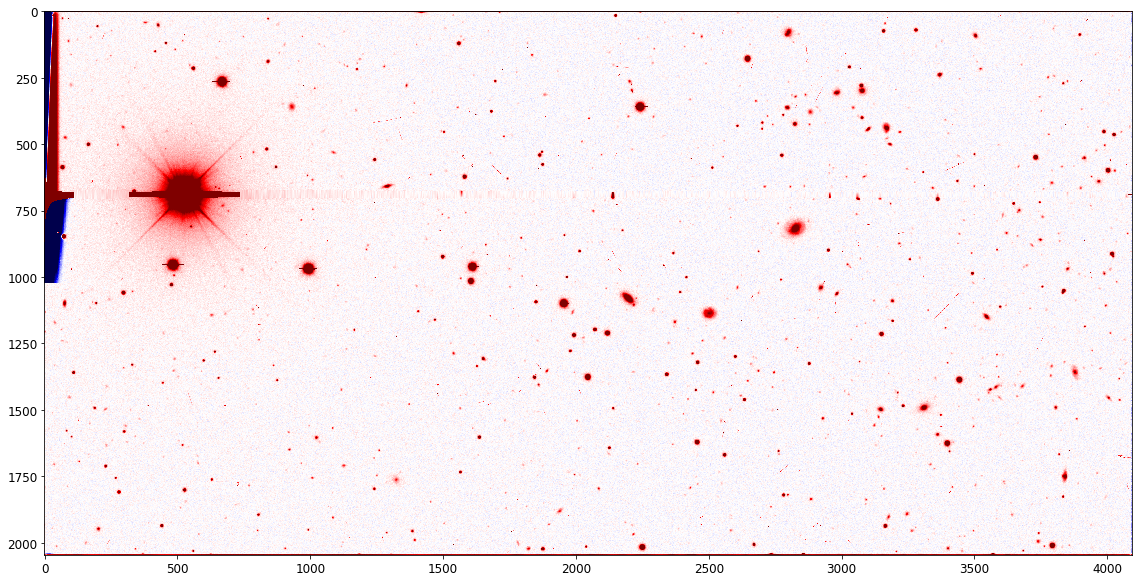

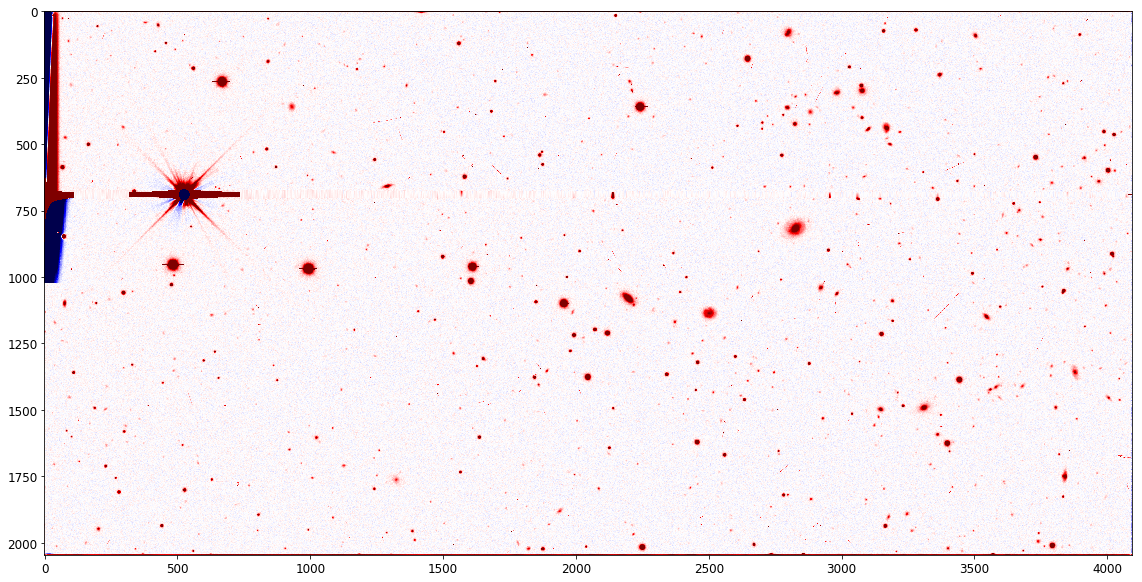

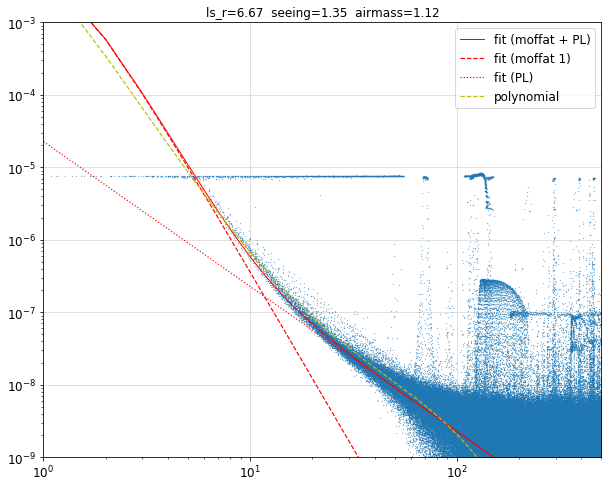

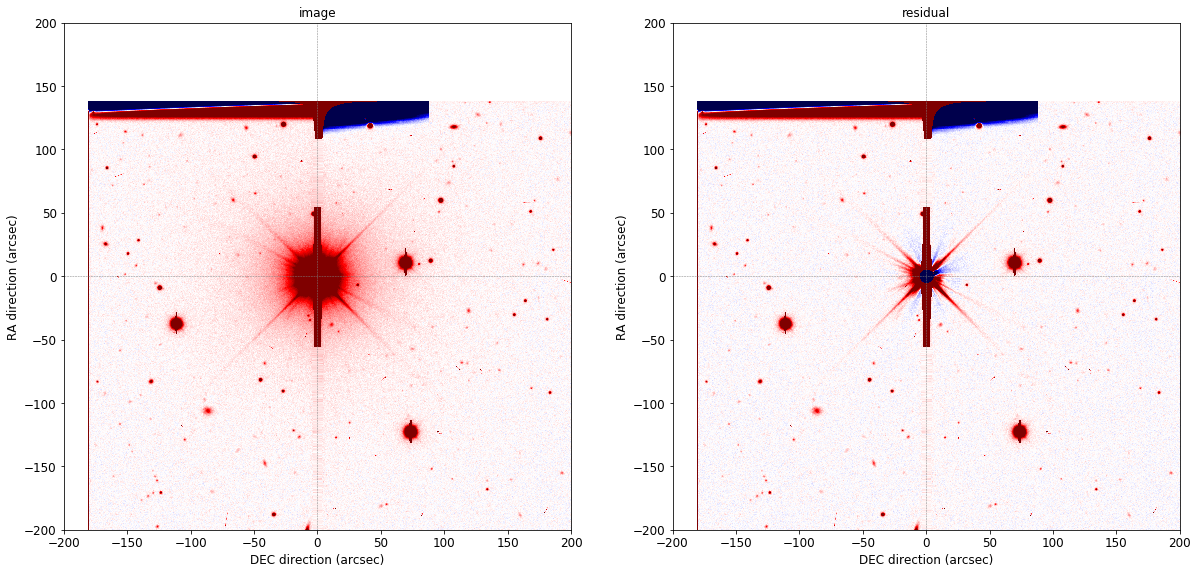

In [11]:
ra, dec = gaia['ra'][gaia_index], gaia['dec'][gaia_index]
print(ra, dec)
print('phot_g_mean_mag = ', gaia['phot_g_mean_mag'][gaia_index])
print('ls_'+band+' = ', gaia['ls_'+band][gaia_index])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    size_str = '200' # 200 is the maximum cutout size

    file_path = os.path.join(download_dir, field, '{}_{}.tgz'.format(gaia['source_id'][gaia_index], size_str))
    if not os.path.exists(os.path.dirname(file_path)):
        os.makedirs(os.path.dirname(file_path))

    # if (not os.path.isfile(file_path)) or (os.stat(file_path).st_size==0):
    #     url = 'http://legacysurvey.org/viewer/cutouts-tgz/?ra={:f}&dec={:f}&size={}&layer=dr8-{}'.format(ra, dec, size_str, field)
    #     cmd = 'wget -O '+file_path+' \"'+url+'\"'
    #     print(cmd)
    #     os.system(cmd)

    tar = tarfile.open(file_path)
    img_dir = os.path.join(os.path.dirname(file_path), tar.getnames()[0])
    if not os.path.exists(img_dir):
        tar.extractall(path=os.path.dirname(file_path))

    ######################################################

    ccd1 = Table.read(os.path.join(img_dir, 'ccds.fits'))
    ccd1 = ccd1[ccd1['filter']==band]
    ccd1.sort('image_filename')
    print(len(ccd1), 'CCD images available')

    expnum_str = str(ccd1['expnum'][ccd1_index])
    fn_prefix = ccd1['camera'][ccd1_index]+'-'+(5-len(expnum_str[:3]))*'0'+expnum_str+'-'+str.rstrip(ccd1['ccdname'][ccd1_index])
    # print(fn_prefix)
    print('seeing = {:.2f} arcsec'.format(ccd1['seeing'][ccd1_index]))
    print('airmass = {:.2f}'.format(ccd1['airmass'][ccd1_index]))

    ######################################################

    radius_min = 1.5*pixscale
    radius_max = 5.0
    moffat_norm = params[band+'_moffat_norm']

    ########## PSFEx ###########
    fn = os.path.join(img_dir, fn_prefix+'-psfex.fits')
    hdu = fits.open(fn)
    data = hdu[1].data

    psf0 = data['psf_mask'][0, 0]
    # normalize to a 22.5 magnitude star
    psf0 = psf0/np.sum(psf0)

    # vrange = 0.0002
    # ax = plot_cutout(psf0, pixscale, vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'])
    # plt.show()

    grid = pixscale * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    ################# Moffat fit ##############

    radius_arr = np.arange(radius_min, radius_max, pixscale)
    flux_frac = np.zeros(len(radius_arr))
    psf0_flat = psf0.flatten()
    for index in range(len(radius_arr)):
        flux_frac[index] = np.sum(psf0_flat[radius<radius_arr[index]])/(moffat_norm*np.sum(psf0))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        popt, pcov = curve_fit(get_frac_moffat, radius_arr, flux_frac)
        print('alpha, beta = ', popt)

    alpha, beta = popt
    flux_frac_fit = get_frac_moffat(radius_arr, alpha, beta)
    psf_moffat_fit = pixscale**2 * get_sb_moffat(radius_arr, alpha, beta)
    psf_moffat_predict = pixscale**2 * get_sb_moffat(radius_grid, alpha, beta)

    # radius_plot = np.linspace(0, 100, 1000)
    # psf_moffat_plot = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore")
    #     plt.figure(figsize=(8, 6))
    #     plt.loglog(radius, (psf0).flatten(), '.', ms=1.)
    #     plt.loglog(radius_plot, psf_moffat_plot, '-', label='moffat')
    #     mask = radius_plot>0.5
    #     plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], '--', lw=1.2, label='polynomial')
    #     plt.axis([0.2, 10, 3e-6, 0.05])
    #     plt.grid(alpha=0.5)
    #     # plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum, ccdname, alpha, beta))
    #     plt.legend()
    #     plt.show()

    ######################################################

    ccd_index = np.where((ccd['expnum']==ccd1['expnum'][ccd1_index]) & (ccd['ccdname']==str.rstrip(ccd1['ccdname'][ccd1_index])))[0][0]
    # print(ccd_index)
    ccd[[ccd_index]]

    image_dir = '/global/project/projectdirs/cosmo/staging/'
    fn = os.path.join(image_dir, ccd['image_filename'][ccd_index])
    # print(fn)

    hdulist = fits.open(fn)
    # print(hdu[ccd['image_hdu'][ccd_index]].header)
    img_raw = hdulist[ccd['image_hdu'][ccd_index]].data

    # naive sky subtraction
    mask = (img_raw<np.percentile(img_raw.flatten(), 85))
    img = img_raw - np.median(img_raw[mask].flatten())
    # convert to nanomaggie per pixel
    img = img / 10**((ccd1['ccdzpt'][ccd1_index]-22.5)/2.5) / ccd1['exptime'][ccd1_index]

    # plt.hist(img.flatten(), 100, range=(-0.02, 0.02))
    # plt.axvline(0, color='red')
    # plt.show()

    plt.figure(figsize=(20, 10))
    plt.imshow(img.T, cmap='seismic', vmin=-vrange, vmax=vrange)
    plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_img.png'.format(band, band, gaia_index, ccd1_index))
    plt.show()

    beta2, weight2 = params[band+'_beta2'], params[band+'_weight2']
    if band=='z':
        alpha2 = params[band+'_alpha2']

    xgrid = pixscale * np.linspace(-0.5*(img.shape[1]-1), 0.5*(img.shape[1]-1), img.shape[1])
    ygrid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
    xx, yy = np.meshgrid(xgrid, ygrid)

    # astrometric correction
    ccdraoff, ccddecoff = -ccd1['ccdraoff'][ccd1_index], -ccd1['ccddecoff'][ccd1_index]

    w = wcs.WCS(hdulist[ccd['image_hdu'][ccd_index]].header)
    xpixcenter, ypixcenter = w.wcs_world2pix([[ra, dec]], True)[0]
    ccddecoff += pixscale*(xpixcenter-(img.shape[1]/2+0.5))
    ccdraoff += pixscale*(ypixcenter-(img.shape[0]/2+0.5))

    xx, yy = xx - ccddecoff, yy - ccdraoff

    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()
    radius_plot = np.linspace(0, 1000, 1000)
    flux = img.flatten()
    # normalization of a 22.5 magnitude star
    norm_factor =  10**((gaia['ls_'+band][gaia_index]-22.5)/2.5)
    
    if band!='z':
        img_predict = pixscale**2 * get_sb_moffat_plus_power_law(radius_grid, alpha, beta, beta2, weight2) / norm_factor
        flux_plot = pixscale**2 * get_sb_moffat_plus_power_law(radius_plot, alpha, beta, beta2, weight2)
        flux_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
        flux_plot2 = weight2 * pixscale**2 * radius_plot**(-2*beta2)
    else:
        img_predict = pixscale**2 * get_sb_double_moffat(radius_grid, alpha, beta, alpha2, beta2, weight2) / norm_factor
        flux_plot = pixscale**2 * get_sb_double_moffat(radius_plot, alpha, beta, alpha2, beta2, weight2)
        flux_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
        flux_plot2 = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

    plt.figure(figsize=(20, 10))
    plt.imshow((img-img_predict).T, cmap='seismic', vmin=-vrange, vmax=vrange)
    plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_img_subtr.png'.format(band, band, gaia_index, ccd1_index))
    plt.show()

    mask = radius<500
    plt.figure(figsize=(10, 8))
    plt.loglog((radius[mask])[::10], norm_factor*(flux[mask])[::10], '.', ms=0.4)
    plt.loglog(radius_plot, flux_plot, 'r-', lw=1, label='fit (moffat + PL)')
    plt.loglog(radius_plot, flux_plot1, 'r--', lw=1.2, alpha=1., label='fit (moffat 1)')
    plt.loglog(radius_plot, flux_plot2, 'r:', lw=1.2, alpha=1., label='fit (PL)')
    mask = radius_plot>0.5
    plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot[mask]))), 'y--', lw=1.2, label='polynomial')
    plt.axis([1, 500, 1e-9, 1e-3])
    plt.grid(alpha=0.5)
    plt.title('ls_{}={:.2f}  seeing={:.2f}  airmass={:.2f}'.format(band, gaia['ls_'+band][gaia_index], ccd1['seeing'][ccd1_index], ccd1['airmass'][ccd1_index]))
    plt.legend()
    plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_profile.png'.format(band, band, gaia_index, ccd1_index))
    plt.show()

    ax = plot_cutout_sidebyside(img, img-img_predict, 'image', 'residual', pixscale, decraoff=[ccddecoff, ccdraoff], vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'], axis=[-200, 200, -200, 200])
    plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_sidebyside.png'.format(band, band, gaia_index, ccd1_index))
    plt.show()

-----
## More plots

In [12]:
for gaia_index in range(0, 120, 4):
    print(gaia_index)

    ra, dec = gaia['ra'][gaia_index], gaia['dec'][gaia_index]
    # print(ra, dec)
    print('phot_g_mean_mag = ', gaia['phot_g_mean_mag'][gaia_index])
    print('ls_'+band+' = ', gaia['ls_'+band][gaia_index])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        size_str = '200' # 200 is the maximum cutout size

        file_path = os.path.join(download_dir, field, '{}_{}.tgz'.format(gaia['source_id'][gaia_index], size_str))
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))

        # if (not os.path.isfile(file_path)) or (os.stat(file_path).st_size==0):
        #     url = 'http://legacysurvey.org/viewer/cutouts-tgz/?ra={:f}&dec={:f}&size={}&layer=dr8-{}'.format(ra, dec, size_str, field)
        #     cmd = 'wget -O '+file_path+' \"'+url+'\"'
        #     print(cmd)
        #     os.system(cmd)

        tar = tarfile.open(file_path)
        img_dir = os.path.join(os.path.dirname(file_path), tar.getnames()[0])
        if not os.path.exists(img_dir):
            tar.extractall(path=os.path.dirname(file_path))

        ######################################################

        ccd1 = Table.read(os.path.join(img_dir, 'ccds.fits'))
        ccd1 = ccd1[ccd1['filter']==band]
        ccd1.sort('image_filename')
        print(len(ccd1), 'CCD images available')

        for ccd1_index in range(len(ccd1)):

            expnum_str = str(ccd1['expnum'][ccd1_index])
            fn_prefix = ccd1['camera'][ccd1_index]+'-'+(5-len(expnum_str[:3]))*'0'+expnum_str+'-'+str.rstrip(ccd1['ccdname'][ccd1_index])
            # print(fn_prefix)
            # print('seeing = {:.2f} arcsec'.format(ccd1['seeing'][ccd1_index]))
            # print('airmass = {:.2f}'.format(ccd1['airmass'][ccd1_index]))

            ######################################################

            radius_min = 1.5*pixscale
            radius_max = 5.0
            moffat_norm = params[band+'_moffat_norm']

            ########## PSFEx ###########
            fn = os.path.join(img_dir, fn_prefix+'-psfex.fits')
            hdu = fits.open(fn)
            data = hdu[1].data

            psf0 = data['psf_mask'][0, 0]
            # normalize to a 22.5 magnitude star
            psf0 = psf0/np.sum(psf0)

            # vrange = 0.0002
            # ax = plot_cutout(psf0, pixscale, vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'])
            # plt.close()

            grid = pixscale * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
            xx, yy = np.meshgrid(grid, grid)
            radius_grid = np.sqrt(xx**2 + yy**2)
            radius = radius_grid.flatten()

            ################# Moffat fit ##############

            radius_arr = np.arange(radius_min, radius_max, pixscale)
            flux_frac = np.zeros(len(radius_arr))
            psf0_flat = psf0.flatten()
            for index in range(len(radius_arr)):
                flux_frac[index] = np.sum(psf0_flat[radius<radius_arr[index]])/(moffat_norm*np.sum(psf0))

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                popt, pcov = curve_fit(get_frac_moffat, radius_arr, flux_frac)
                print('alpha, beta = ', popt)

            alpha, beta = popt
            flux_frac_fit = get_frac_moffat(radius_arr, alpha, beta)
            psf_moffat_fit = pixscale**2 * get_sb_moffat(radius_arr, alpha, beta)
            psf_moffat_predict = pixscale**2 * get_sb_moffat(radius_grid, alpha, beta)

            # radius_plot = np.linspace(0, 100, 1000)
            # psf_moffat_plot = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
            # with warnings.catch_warnings():
            #     warnings.simplefilter("ignore")
            #     plt.figure(figsize=(8, 6))
            #     plt.loglog(radius, (psf0).flatten(), '.', ms=1.)
            #     plt.loglog(radius_plot, psf_moffat_plot, '-', label='moffat')
            #     mask = radius_plot>0.5
            #     plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], '--', lw=1.2, label='polynomial')
            #     plt.axis([0.2, 10, 3e-6, 0.05])
            #     plt.grid(alpha=0.5)
            #     # plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum, ccdname, alpha, beta))
            #     plt.legend()
            #     plt.close()

            ######################################################

            ccd_index = np.where((ccd['expnum']==ccd1['expnum'][ccd1_index]) & (ccd['ccdname']==str.rstrip(ccd1['ccdname'][ccd1_index])))[0][0]
            # print(ccd_index)
            ccd[[ccd_index]]

            image_dir = '/global/project/projectdirs/cosmo/staging/'
            fn = os.path.join(image_dir, ccd['image_filename'][ccd_index])
            # print(fn)

            hdulist = fits.open(fn)
            # print(hdu[ccd['image_hdu'][ccd_index]].header)
            img_raw = hdulist[ccd['image_hdu'][ccd_index]].data

            # naive sky subtraction
            mask = (img_raw<np.percentile(img_raw.flatten(), 85))
            img = img_raw - np.median(img_raw[mask].flatten())
            # convert to nanomaggie per pixel
            img = img / 10**((ccd1['ccdzpt'][ccd1_index]-22.5)/2.5) / ccd1['exptime'][ccd1_index]

            # plt.hist(img.flatten(), 100, range=(-0.02, 0.02))
            # plt.axvline(0, color='red')
            # plt.close()

            plt.figure(figsize=(20, 10))
            plt.imshow(img.T, cmap='seismic', vmin=-vrange, vmax=vrange)
            plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_img.png'.format(band, band, gaia_index, ccd1_index))
            plt.close()

            beta2, weight2 = params[band+'_beta2'], params[band+'_weight2']
            if band=='z':
                alpha2 = params[band+'_alpha2']

            xgrid = pixscale * np.linspace(-0.5*(img.shape[1]-1), 0.5*(img.shape[1]-1), img.shape[1])
            ygrid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
            xx, yy = np.meshgrid(xgrid, ygrid)

            # astrometric correction
            ccdraoff, ccddecoff = -ccd1['ccdraoff'][ccd1_index], -ccd1['ccddecoff'][ccd1_index]

            w = wcs.WCS(hdulist[ccd['image_hdu'][ccd_index]].header)
            xpixcenter, ypixcenter = w.wcs_world2pix([[ra, dec]], True)[0]
            ccddecoff += pixscale*(xpixcenter-(img.shape[1]/2+0.5))
            ccdraoff += pixscale*(ypixcenter-(img.shape[0]/2+0.5))

            xx, yy = xx - ccddecoff, yy - ccdraoff

            radius_grid = np.sqrt(xx**2 + yy**2)
            radius = radius_grid.flatten()
            radius_plot = np.linspace(0, 1000, 1000)
            flux = img.flatten()
            # normalization of a 22.5 magnitude star
            norm_factor =  10**((gaia['ls_'+band][gaia_index]-22.5)/2.5)

            if band!='z':
                img_predict = pixscale**2 * get_sb_moffat_plus_power_law(radius_grid, alpha, beta, beta2, weight2) / norm_factor
                flux_plot = pixscale**2 * get_sb_moffat_plus_power_law(radius_plot, alpha, beta, beta2, weight2)
                flux_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
                flux_plot2 = weight2 * pixscale**2 * radius_plot**(-2*beta2)
            else:
                img_predict = pixscale**2 * get_sb_double_moffat(radius_grid, alpha, beta, alpha2, beta2, weight2) / norm_factor
                flux_plot = pixscale**2 * get_sb_double_moffat(radius_plot, alpha, beta, alpha2, beta2, weight2)
                flux_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
                flux_plot2 = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

            plt.figure(figsize=(20, 10))
            plt.imshow((img-img_predict).T, cmap='seismic', vmin=-vrange, vmax=vrange)
            plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_img_subtr.png'.format(band, band, gaia_index, ccd1_index))
            plt.close()

            mask = radius<500
            plt.figure(figsize=(10, 8))
            plt.loglog((radius[mask])[::10], norm_factor*(flux[mask])[::10], '.', ms=0.4)
            plt.loglog(radius_plot, flux_plot, 'r-', lw=1, label='fit (moffat + PL)')
            plt.loglog(radius_plot, flux_plot1, 'r--', lw=1.2, alpha=1., label='fit (moffat 1)')
            plt.loglog(radius_plot, flux_plot2, 'r:', lw=1.2, alpha=1., label='fit (PL)')
            mask = radius_plot>0.5
            plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot[mask]))), 'y--', lw=1.2, label='polynomial')
            plt.axis([1, 500, 1e-9, 1e-3])
            plt.grid(alpha=0.5)
            plt.title('ls_{}={:.2f}  seeing={:.2f}  airmass={:.2f}'.format(band, gaia['ls_'+band][gaia_index], ccd1['seeing'][ccd1_index], ccd1['airmass'][ccd1_index]))
            plt.legend()
            plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_profile.png'.format(band, band, gaia_index, ccd1_index))
            plt.close()

            ax = plot_cutout_sidebyside(img, img-img_predict, 'image', 'residual', pixscale, decraoff=[ccddecoff, ccdraoff], vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'], axis=[-200, 200, -200, 200])
            plt.savefig('/global/homes/r/rongpu/temp/plots/bright_star_profile/{}/{}_{}_{}_sidebyside.png'.format(band, band, gaia_index, ccd1_index))
            plt.close()

0
phot_g_mean_mag =  6.80578
ls_r =  6.67489347293
3 CCD images available
alpha, beta =  [ 0.96814433  2.44850762]
alpha, beta =  [ 1.00636352  2.48385314]
alpha, beta =  [ 0.62141525  2.27407562]
4
phot_g_mean_mag =  6.77157
ls_r =  6.61712315265
3 CCD images available
alpha, beta =  [ 0.36561763  1.97945193]
alpha, beta =  [ 0.71517391  2.320165  ]
alpha, beta =  [ 0.56897596  2.10501984]
8
phot_g_mean_mag =  6.59423
ls_r =  6.44634591461
4 CCD images available
alpha, beta =  [ 0.97001939  2.49705408]
alpha, beta =  [ 0.55061589  2.1281925 ]
alpha, beta =  [ 0.58392293  2.28086179]
alpha, beta =  [ 0.69834715  2.37252113]
12
phot_g_mean_mag =  6.73108
ls_r =  6.74389485998
5 CCD images available
alpha, beta =  [ 0.4953693   2.11207743]
alpha, beta =  [ 0.47287835  2.09897458]
alpha, beta =  [ 1.18999758  2.75255928]
alpha, beta =  [ 0.48330978  2.16945269]
alpha, beta =  [ 0.55258783  2.18135787]
16
phot_g_mean_mag =  6.79504
ls_r =  6.66016627088
4 CCD images available
alpha, beta =